# Manual runs of VQC
### Note:
1. For the manual runs control values are set in modules.config
2. It also possible to run automatically

Import modules needed:

In [1]:
import numpy as np
import copy
import time
from pathlib import Path
from time import strftime

from modules.helper_functions_tsp import (find_problem_size, 
                                          cost_fn_fact, 
                                          hot_start, 
                                          convert_bit_string_to_cycle, 
                                          hot_start_list_to_string,
                                          update_parameters_using_gradient, 
                                          define_parameters, 
                                          create_initial_rotations,
                                          bind_weights, 
                                          vqc_circuit, 
                                          cost_func_evaluate, 
                                          find_run_stats,
                                          find_distances_array,
                                          detect_quantum_GPU_support, 
                                         )

from modules.graph_functions import (parameter_graph, 
                                     cost_graph_multi,
                                     )

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

Set random seed so results are reproducible for testing.

In [2]:
np.random.seed(42)

Import constants needed.  Note that most are read directly from modules.config:

In [3]:
from modules.config import (ROTATIONS, 
                            VERBOSE, 
                            CHANGE_EACH_PARAMETER, 
                            PLOT_PARAMETER_EVALUATION,
                            SLICES, 
                            )

In [4]:
if detect_quantum_GPU_support():
    print('GPU support detected')
else:
    print('GPU support not detected')

GPU support not detected


Instantiate data logger - this will create a folder for graphs and results:


In [5]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_quantum_constants_from_config()
#sdl.quantum = True
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20251012-08-47-53 - 08-47-53


Read in the control file
The executions are controlled by a CSV parameter file in the control directory

From the number of locations visited find the qubits and longest binary string.

In [6]:
qubits = find_problem_size(sdl.locations, sdl.formulation)
sdl.qubits = qubits
print(f'There are {qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')
print(f'Running mode {sdl.mode} with {sdl.shots} shots')

There are 3 qubits needed for 4 locations in the original formulation.
Running mode 2 with 1024 shots


Data sources are held locally to avoid downstream dependencies.  Read the data, and print out the filename and best distance held in the data.  Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array, best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\four_d.txt.
It is known that the shortest distance is 21


Define the VQC circuits with appropriate parameters, and draw the circuit.

Number of parameters to be optimized is 12
Parameters are: [Parameter(param 0), Parameter(param 1), Parameter(param 2), Parameter(param 3), Parameter(param 4), Parameter(param 5), Parameter(param 6), Parameter(param 7), Parameter(param 8), Parameter(param 9), Parameter(param 10), Parameter(param 11)]


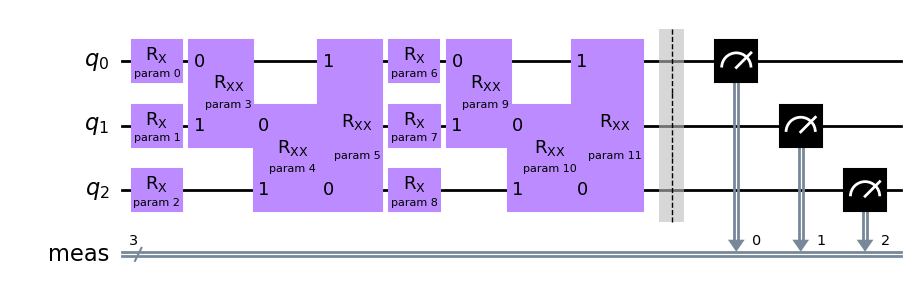

In [8]:
sdl.num_params = sdl.calculate_parameter_numbers()
print(f'Number of parameters to be optimized is {sdl.num_params}')
params = define_parameters(sdl)

print(f'Parameters are: {params}')
qc = vqc_circuit(sdl, params)

filename = Path.joinpath(datalogger.graph_sub_path, f'initial_unbound_circuit.png')
qc.draw("mpl", style="clifford", filename=filename )

Determine the cost function.  This receives a binary list and returns a real value:

In [9]:
cost_fn = cost_fn_fact(sdl.locations,distance_array, sdl.gray, method = sdl.formulation)

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The initial parameters (weights) are [2.26310383 3.93973343 5.40682681 5.40091158 0.2913334  0.29045982
 1.10278303 4.26513795 4.82855271 2.07417812 1.84158992 1.93445813]


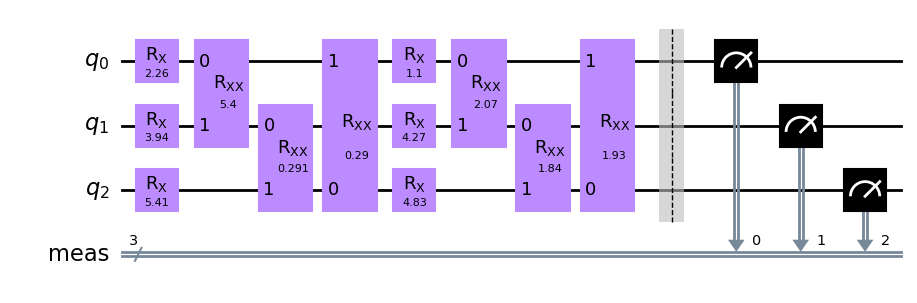

In [10]:
bin_hot_start_list=[]
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, 
                                                   sdl.locations, 
                                                   sdl.gray, 
                                                   sdl.formulation
                                                   )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    hot_start_distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {hot_start_distance}, compared to a best distance of {best_dist}.')
init_rots = create_initial_rotations(qubits, 
                                     sdl.mode,
                                     sdl.layers,
                                     bin_hot_start_list=bin_hot_start_list,
                                     hot_start=sdl.hot_start,
                                     )
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
filename = Path.joinpath(datalogger.graph_sub_path, f'initial_bound_circuit.png')
bc.draw("mpl", style="clifford", filename=filename )

In [11]:
print([p.name for p in qc.parameters])
print([str(p) for p in params])

['param 0', 'param 1', 'param 10', 'param 11', 'param 2', 'param 3', 'param 4', 'param 5', 'param 6', 'param 7', 'param 8', 'param 9']
['param 0', 'param 1', 'param 2', 'param 3', 'param 4', 'param 5', 'param 6', 'param 7', 'param 8', 'param 9', 'param 10', 'param 11']


Find average and lowest cost for the starting circuit, and print these:

In [12]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, 
                                                   sdl.noise,
                                                   bc, 
                                                   shots=sdl.shots, 
                                                   average_slice=SLICES[0], 
                                                   verbose=VERBOSE,
                                                   )
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 22.5 and the lowest cost is 21.0


Next we test the impact of varying each parameter in turn on the average cost for the first slicing ratio mentioned.  These results are not saved with the data logger.

In [13]:
if CHANGE_EACH_PARAMETER:
    average_slice = SLICES[0]
    param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])
    cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
    if VERBOSE:
        print(f'init_rots = {init_rots}')
    #need deep copy in case init_rots is changed
    for i in range(sdl.num_params):
        rots = copy.deepcopy(init_rots)
        if VERBOSE:
            print(f'Processing parameter {i}')
            print(f'rots = {rots}, init_rots = {init_rots}')
        cost_list, lowest_list, sliced_cost_list  = [], [], []
        for angle in param_values:
            rots[i] = angle
            bc = bind_weights(params, rots, qc)
            sliced_cost, _ , _ = cost_func_evaluate(cost_fn, 
                                                    sdl.noise,
                                                    bc, 
                                                    sdl.shots, 
                                                    average_slice=average_slice, 
                                                    verbose=VERBOSE
                                                    )
            cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, 
                                                                        sdl.noise,
                                                                        bc, 
                                                                        sdl.shots, 
                                                                        average_slice=1, 
                                                                        verbose=VERBOSE
                                                                        )
            route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, 
                                                     sdl.locations, 
                                                     gray=sdl.gray, 
                                                     method=sdl.formulation
                                                     )
            cost_list.append(cost)
            lowest_list.append(lowest)
            sliced_cost_list.append(sliced_cost)
            if VERBOSE:
                print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
                print(f'The full parameter vector is {rots}')
                print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
                print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
        cost_list_all.append(cost_list)
        lowest_list_all.append(lowest_list)     
        sliced_cost_list_all.append(sliced_cost_list)
    items, hits, misses = cost_fn.report_cache_stats()
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

The results of changing the parameters are printed out:

In [14]:
if CHANGE_EACH_PARAMETER:
    filename = Path.joinpath(datalogger.graph_sub_path,'Parameter_values')
    main_title = f'Av and lowest energy (distance) found by changing each parameter in turn with slices = {SLICES[0]}'
    sub_title = 'Parameter '
    x_label = 'Gate rotation in Radians'
    param_names = [i for i in range(sdl.num_params)]
    cost_graph_multi(filename, 
                     param_names, 
                     param_values, 
                     cost_list_all, 
                     lowest_list_all, 
                     sliced_cost_list_all, 
                     best_dist, 
                     main_title, 
                     sub_title, 
                     x_label
                     )

The evolution of the parameters is calculated and stored:

In [15]:
if PLOT_PARAMETER_EVALUATION:
    sdl.slice = SLICES[0]

    average_slice = SLICES[0]
    #only do for one slice

    output_data = update_parameters_using_gradient(sdl,
                                                   params=params,
                                                   rots=init_rots,
                                                   cost_fn=cost_fn,
                                                   qc=qc,
                                                  )

    index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = output_data

    cost_fn.print_cache_stats
    cost_fn.clear_cache() #need to clear cache so statistics are not cumulative

The evolution of the parameters is plotted.

In [16]:
if PLOT_PARAMETER_EVALUATION:
    legend = [params[i].name for i in range(len(params))] 
    short_title = 'Evolution of parameters -'
    full_title = short_title + f' {sdl.formulation} formulation, hot start = {sdl.hot_start}'
    filename = Path.joinpath(datalogger.graph_sub_path,short_title)
    parameter_graph(filename, full_title, index_l, parameter_l, legend)

Do a run for each slice, time, and save results.

In [17]:
rots = copy.deepcopy(init_rots)
av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
sdl_list = []
for i, slice in enumerate(SLICES):
    t0 = time.time()
    sdl_list.append(MySubDataLogger(runid=datalogger.runid))
    sdl_list[i].update_general_constants_from_config()
    sdl_list[i].update_quantum_constants_from_config()
    sdl_list[i].quantum = True
    sdl_list[i].slice = slice
    sdl_list[i].qubits = qubits
    
    new_output_data = update_parameters_using_gradient(sdl_list[i],
                                                       params=params,
                                                       rots=init_rots,
                                                       cost_fn=cost_fn,
                                                       qc=qc,
                                                       verbose=VERBOSE,
                                                       )
                        
    sdl_list[i].index_list, sdl_list[i].sliced_list, sdl_list[i].lowest_list, _ , sdl_list[i].average_list, _ = new_output_data
    
    av_cost_list_all.append(sdl_list[i].average_list)
    lowest_list_all.append(sdl_list[i].lowest_list)
    sliced_cost_list_all.append(sdl_list[i].sliced_list)

    best_dist_found, iteration_found = find_run_stats(sdl_list[i].lowest_list)
    print(f'With a slice of {slice} the best distance found was {best_dist_found} at iteration {iteration_found }')
    print(f'This is compared to the best distance of {best_dist}, giving a quality of {best_dist/best_dist_found:.1%}')
    if sdl_list[i].hot_start:
        sdl_list[i].hot_start_dist = hot_start_distance
    sdl_list[i].best_dist_found = best_dist_found
    sdl_list[i].best_dist = best_dist
    sdl_list[i].iteration_found = iteration_found

    t1 = time.time()
    elapsed = t1-t0
    print(f'The time taken to run the code is {elapsed:.3f} seconds')
    sdl_list[i].elapsed = elapsed
    sdl_list[i].update_cache_statistics(cost_fn)
    sdl_list[i].save_results_to_csv()
    sdl_list[i].save_detailed_results()

SubDataLogger instantiated.  Run ID = 20251012-08-47-53 - 08-47-55
With a slice of 0.8 the best distance found was 21.0 at iteration 0
This is compared to the best distance of 21, giving a quality of 100.0%
The time taken to run the code is 13.190 seconds
Saving data to results\results.csv
Detailed data for Run ID: 20251012-08-47-53 - 08-47-55 successfully added to results\20251012-08-47-53\08-47-55.csv


In [18]:
sdl_list[0].update_cache_statistics(cost_fn)

The results are saved.  Note, the formulation, hot_start, gradient type and locations are the same for each sub-run so are taken from the last run:

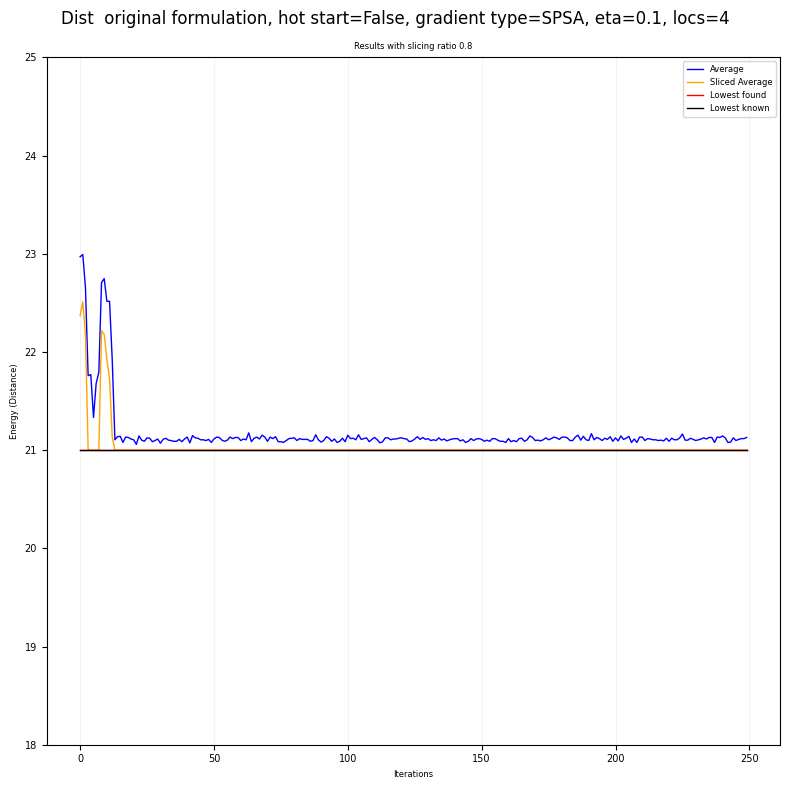

In [19]:
short_title = 'Dist '
full_title = short_title + f' {sdl.formulation} formulation, hot start={sdl.hot_start}, '
full_title = full_title + f'gradient type={sdl.gradient_type}, eta={sdl.eta}, locs={sdl.locations}'
filename = Path.joinpath(datalogger.graph_sub_path,short_title)
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
if SLICES  == [1]:
    sliced_cost_list_all = None

cost_graph_multi(filename, 
                 SLICES, 
                 sdl_list[0].index_list,
                 av_cost_list_all, 
                 lowest_list_all, 
                 sliced_cost_list_all, 
                 best_dist, 
                 full_title, 
                 sub_title,
                 x_label,
                )